In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import time

# References:
# https://github.com/log0/higgs_boson/blob/master/cleaned_model.py
# http://opendata.cern.ch/record/328

# Data downloadable from:
# http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz

In [2]:
#data = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")
data = pd.read_csv("http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz")

# drop the columns KaggleSet and KaggleWeight which were made specifically for the Kaggle ML challenge.
data = data.drop(["KaggleSet", "KaggleWeight"], axis = 1)

print(data.shape)

(818238, 33)


In [3]:
display(data)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.200,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.000,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.000,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.000,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.000,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,256.853,0.659,1.343,0.000,61.970,2.074,1.874,40.827,2.098,-3.131,72.892,2.273,303.668,2,112.264,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,248.582,1.429,1.398,0.586,28.711,-1.724,0.070,41.015,-1.573,2.359,34.940,1.541,266.919,2,108.698,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,68.097,0.642,-0.836,-999.000,41.478,1.057,1.025,26.619,1.087,-1.717,30.463,-2.064,188.648,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,101.676,0.936,1.410,-999.000,36.575,-1.249,-1.540,34.238,-1.216,0.939,6.647,-0.511,212.565,1,30.863,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b


In [4]:
# For the column Label, s: signal, b: background.

print(data["Label"].unique())

# Remap s to 1 and b to 0 to a binary classification problem: [0, 1]
# "s": "signal", "b": "background"

def str_to_int(s):
    if s == "s":
        i = 1
    elif s == "b":
        i = 0
    return i

def int_to_str(i):
    if i == 1:
        s = "s"
    elif i == 0:
        s = "b"
    return s

data["Label"] = data["Label"].apply(str_to_int)

['s' 'b']


In [5]:
# Check the number and fraction of -999 values per column.

to_drop = []
for i in data.columns:
    N_999 = np.sum(data[i] == -999)
    f_999 = N_999 / len(data)
    if f_999 >= 0.4:
        to_drop.append(i)
    print("{:30s}: {:6d} | {:.3f}".format(i, N_999, f_999))

EventId                       :      0 | 0.000
DER_mass_MMC                  : 124602 | 0.152
DER_mass_transverse_met_lep   :      0 | 0.000
DER_mass_vis                  :      0 | 0.000
DER_pt_h                      :      0 | 0.000
DER_deltaeta_jet_jet          : 580253 | 0.709
DER_mass_jet_jet              : 580253 | 0.709
DER_prodeta_jet_jet           : 580253 | 0.709
DER_deltar_tau_lep            :      0 | 0.000
DER_pt_tot                    :      0 | 0.000
DER_sum_pt                    :      0 | 0.000
DER_pt_ratio_lep_tau          :      0 | 0.000
DER_met_phi_centrality        :      0 | 0.000
DER_lep_eta_centrality        : 580253 | 0.709
PRI_tau_pt                    :      0 | 0.000
PRI_tau_eta                   :      0 | 0.000
PRI_tau_phi                   :      0 | 0.000
PRI_lep_pt                    :      0 | 0.000
PRI_lep_eta                   :      0 | 0.000
PRI_lep_phi                   :      0 | 0.000
PRI_met                       :      0 | 0.000
PRI_met_phi  

In [6]:
# Many columns have a large number of -999. Drop those columns.

data = data.drop(to_drop, axis = 1)
display(data)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,3.064,41.928,197.760,1.582,1.396,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,113.497,0.000814,1
1,100001,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.681042,0
2,100002,-999.000,162.172,125.953,35.635,3.148,9.336,197.814,3.776,1.414,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,0.715742,0
3,100003,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-0.000,1.660654,0
4,100004,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.000,1.904263,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,1.279,6.133,256.853,0.659,1.343,61.970,2.074,1.874,40.827,2.098,-3.131,72.892,2.273,303.668,2,154.056,0.005721,1
818234,918234,99.294,30.097,62.713,65.861,2.294,2.889,248.582,1.429,1.398,28.711,-1.724,0.070,41.015,-1.573,2.359,34.940,1.541,266.919,2,178.856,0.000461,1
818235,918235,108.497,9.837,65.149,18.006,2.742,18.006,68.097,0.642,-0.836,41.478,1.057,1.025,26.619,1.087,-1.717,30.463,-2.064,188.648,0,-0.000,1.189365,0
818236,918236,96.711,20.006,66.942,29.761,2.479,2.739,101.676,0.936,1.410,36.575,-1.249,-1.540,34.238,-1.216,0.939,6.647,-0.511,212.565,1,30.863,0.512740,0


In [7]:
# We still have 1 column with -999 values: DER_mass_MMC.
# As only 15% of the data contains -999, drop those rows.

data = data[data["DER_mass_MMC"] != -999]
display(data)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,3.064,41.928,197.760,1.582,1.396,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,113.497,0.000814,1
1,100001,160.937,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.681042,0
3,100003,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-0.000,1.660654,0
4,100004,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.000,1.904263,0
5,100005,89.744,13.550,59.149,116.344,1.362,61.619,278.876,0.588,0.479,53.651,0.371,1.329,31.565,-0.884,1.857,40.735,2.237,282.849,3,193.660,0.025434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,1.279,6.133,256.853,0.659,1.343,61.970,2.074,1.874,40.827,2.098,-3.131,72.892,2.273,303.668,2,154.056,0.005721,1
818234,918234,99.294,30.097,62.713,65.861,2.294,2.889,248.582,1.429,1.398,28.711,-1.724,0.070,41.015,-1.573,2.359,34.940,1.541,266.919,2,178.856,0.000461,1
818235,918235,108.497,9.837,65.149,18.006,2.742,18.006,68.097,0.642,-0.836,41.478,1.057,1.025,26.619,1.087,-1.717,30.463,-2.064,188.648,0,-0.000,1.189365,0
818236,918236,96.711,20.006,66.942,29.761,2.479,2.739,101.676,0.936,1.410,36.575,-1.249,-1.540,34.238,-1.216,0.939,6.647,-0.511,212.565,1,30.863,0.512740,0


In [8]:
# Get the feature, weights and target sets.

X = data.drop(["EventId",  "Weight", "Label"], axis = 1)
y = data["Label"]
W = data["Weight"]

print(X.shape, y.shape, W.shape)

(693636, 20) (693636,) (693636,)


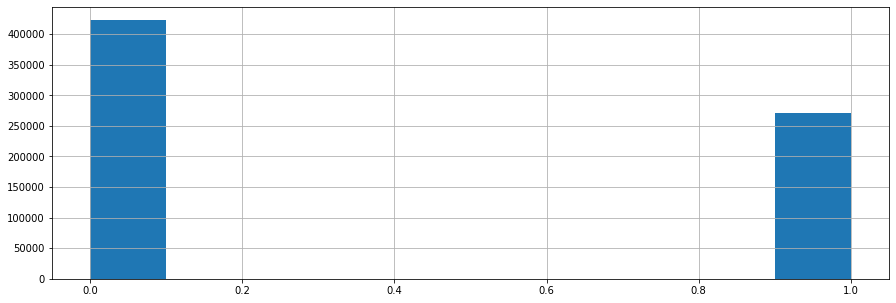

In [9]:
# The signal to background ratio is roughly 1:2, so we don't need to worry too much about imbalance.

plt.figure(figsize = (15, 5))
plt.hist(y)
plt.grid(True)
plt.show()

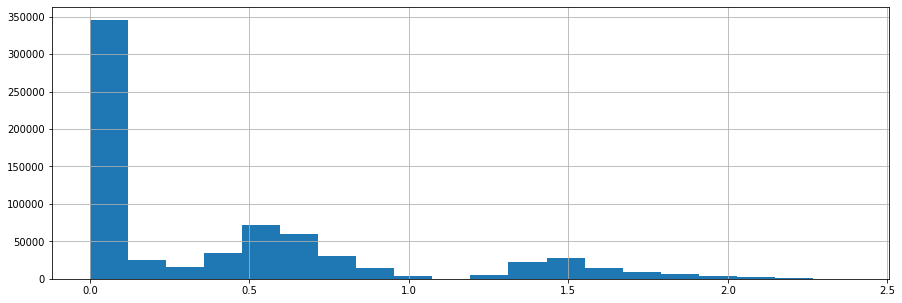

In [10]:
# Check the weight distribution.

plt.figure(figsize = (15, 5))
plt.hist(W, 20)
plt.grid(True)
plt.show()

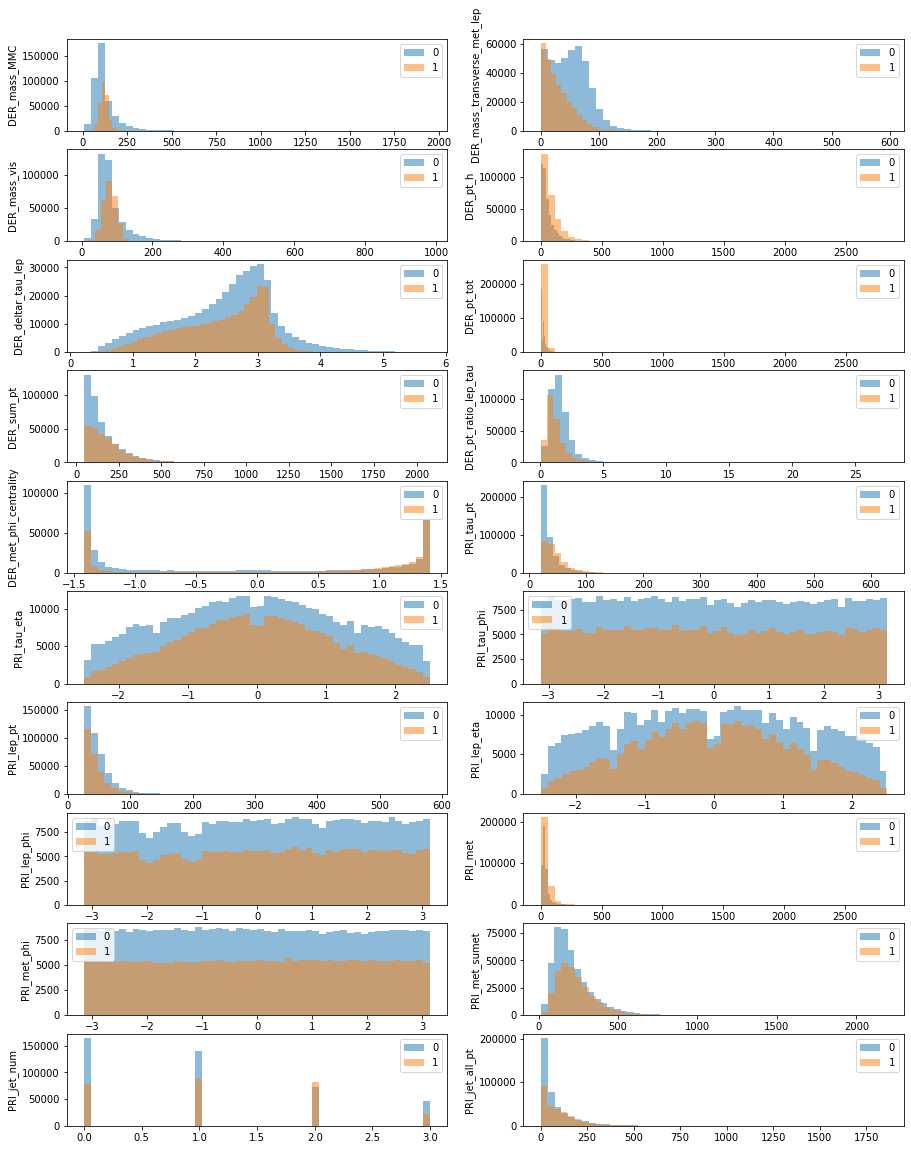

In [11]:
# For each column, check its distribution for both background and signals.

plt.figure(figsize = (15, 20))
for i, col in enumerate(X.columns):
    plt.subplot(int(len(X.columns) / 2), 2, i+1)
    plt.hist(X[y == 0][col], 50, alpha = 0.5) # background distribution
    plt.hist(X[y == 1][col], 50, alpha = 0.5) # signal distribution
    plt.ylabel(col)
    plt.legend(["0", "1"])
plt.show()

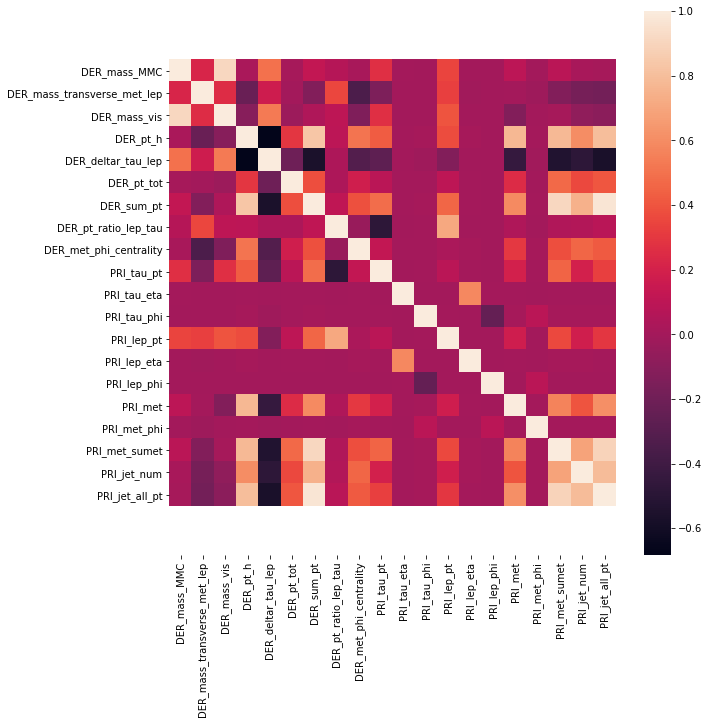

In [12]:
# Check correlations between the different features.
# For some models, it is not good if too many correlated features are used.

plt.figure(figsize = (10, 10))
sns.heatmap(X.corr())
plt.axis("equal")
plt.show()

In [13]:
# Scale and split the data for simple baseline model testing.

X_train, X_test, y_train, y_test, W_train, W_test = train_test_split(X, y, W, stratify = y, train_size = 0.8, random_state = 0)

# Use a MinMaxScaler to scale each column's features to [0, 1]
minmaxscaler = MinMaxScaler()
X_train = minmaxscaler.fit_transform(X_train)
X_test = minmaxscaler.transform(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(W_train.shape, W_test.shape)

(554908, 20) (138728, 20)
(554908,) (138728,)
(554908,) (138728,)


In [14]:
# Accuracy Ratio score: a commonly used variant of the roc_auc_score in the finance industry.

def AR(y_true, y_score, average = 'macro', sample_weight = None, max_fpr = None, multi_class = 'raise', labels = None):
    score = roc_auc_score(y_true, y_score, average=average, sample_weight=sample_weight, max_fpr=max_fpr, multi_class=multi_class, labels=labels)
    return 2 * score - 1

In [15]:
def print_scores(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    if "predict_proba" in dir(model):
        y_train_score = model.predict_proba(X_train)[:, 1]
        y_test_score = model.predict_proba(X_test)[:, 1]
    elif "decision_function" in dir(model):
        y_train_score = model.decision_function(X_train)[:, 1]
        y_test_score = model.decision_function(X_test)[:, 1]
    print("          Train | Test")
    print("Accuracy: {:.3f} | {:.3f}".format(model.score(X_train, y_train), model.score(X_test, y_test)))
    #print("AR      : {:.3f} | {:.3f}".format(AR(y_train, y_train_score), AR(y_test, y_test_score)))
    print("AUC     : {:.3f} | {:.3f}".format(roc_auc_score(y_train, y_train_score), roc_auc_score(y_test, y_test_score)))
    print("Avg Prec: {:.3f} | {:.3f}".format(average_precision_score(y_train, y_train_score), average_precision_score(y_test, y_test_score)))
    print("F1      : {:.3f} | {:.3f}".format(f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)))
    print("MCC     : {:.3f} | {:.3f}".format(matthews_corrcoef(y_train, y_train_pred), matthews_corrcoef(y_test, y_test_pred)))

In [16]:
# Logistic regression

logreg = LogisticRegression(max_iter = 1000)

start_time = time.time()
logreg.fit(X_train, y_train)
print("Time elapsed: {:.2f}s.".format(time.time() - start_time))

print_scores(logreg, X_train, X_test, y_train, y_test)

Time elapsed: 36.77s.
          Train | Test
Accuracy: 0.709 | 0.709
AUC     : 0.774 | 0.776
Avg Prec: 0.635 | 0.637
F1      : 0.599 | 0.598
MCC     : 0.375 | 0.375


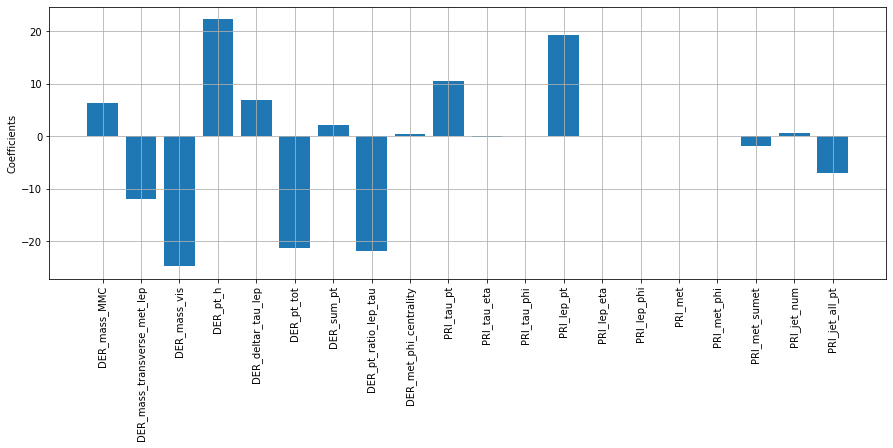

In [17]:
plt.figure(figsize = (15, 5))
plt.bar(X.columns, logreg.coef_[0])
plt.xticks(rotation = 90)
plt.ylabel("Coefficients")
plt.grid(True)
plt.show()

In [19]:
# Random forests

randomforest = RandomForestClassifier(n_estimators = 10, max_depth = 10, random_state = 0)

start_time = time.time()
randomforest.fit(X_train, y_train)
print("Time elapsed: {:.2f}s.".format(time.time() - start_time))

print_scores(randomforest, X_train, X_test, y_train, y_test)

Time elapsed: 24.14s.
          Train | Test
Accuracy: 0.810 | 0.807
AUC     : 0.887 | 0.883
Avg Prec: 0.833 | 0.828
F1      : 0.752 | 0.748
MCC     : 0.599 | 0.592


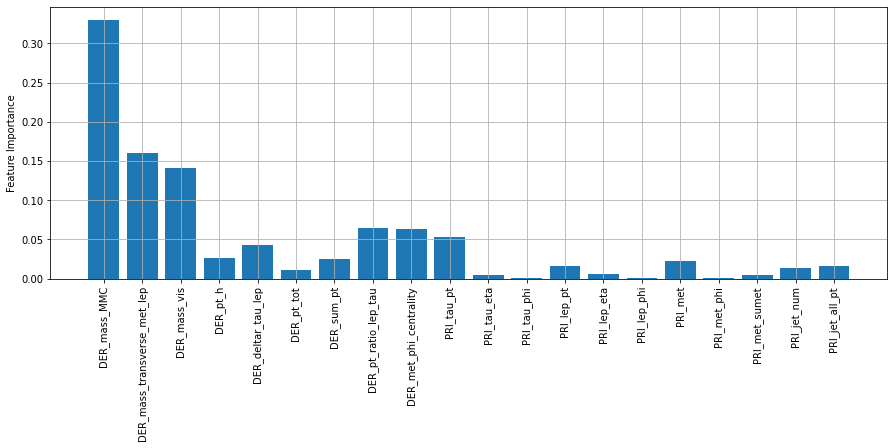

In [20]:
plt.figure(figsize = (15, 5))
plt.bar(X.columns, randomforest.feature_importances_)
plt.xticks(rotation = 90)
plt.ylabel("Feature Importance")
plt.grid(True)
plt.show()

In [21]:
# Light gradient boosted machines

lgbm = LGBMClassifier(n_estimators = 100, max_depth = 10, random_state = 0)

start_time = time.time()
lgbm.fit(X_train, y_train)
print("Time elapsed: {:.2f}s.".format(time.time() - start_time))

print_scores(lgbm, X_train, X_test, y_train, y_test)

Time elapsed: 9.37s.
          Train | Test
Accuracy: 0.816 | 0.814
AUC     : 0.893 | 0.893
Avg Prec: 0.844 | 0.844
F1      : 0.756 | 0.754
MCC     : 0.610 | 0.606


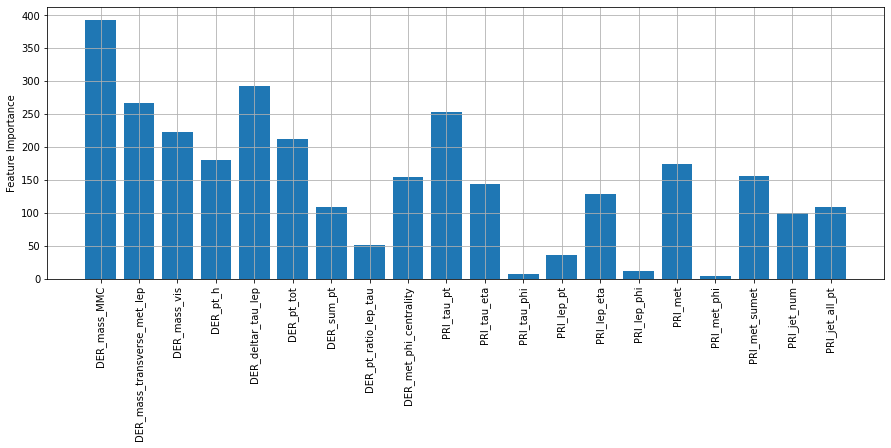

In [22]:
plt.figure(figsize = (15, 5))
plt.bar(X.columns, lgbm.feature_importances_)
plt.xticks(rotation = 90)
plt.ylabel("Feature Importance")
plt.grid(True)
plt.show()

In [23]:
# As the LGBMClassifier appears to have the best performance as well as the fastest.
# Perform cross_val_score to ensure that the scoring is consistent across the entire dataset.

lgbm_cv_rocauc = cross_val_score(lgbm, X, y, cv = 5, scoring = "roc_auc")
print(lgbm_cv_rocauc)

[0.89050977 0.89061221 0.89032722 0.88957811 0.89233658]


In [24]:
# Perform a cross validated grid search for the best lgbm hyper parameters.

#X_0, X_1, y_0, y_1, W_0, W_1 = train_test_split(X, y, W, stratify = y, train_size = 0.7, random_state = 0)

#param_grid = {"n_estimators": [50, 100, 200, 500, 1000]}
#lgbm_gridsearch = GridSearchCV(lgbm, param_grid = param_grid, scoring = "roc_auc", cv = 5)

#start_time = time.time()
#lgbm_gridsearch.fit(X_0, y_0)
#print("Time elapsed: {:.2f}s.".format(time.time() - start_time))

#print("Best parameters: {}".format(lgbm_gridsearch.best_params_))
#print("Best cross-val score: {:.3f}".format(lgbm_gridsearch.best_score_))
#print("Test score: {:.3f}".format(lgbm_gridsearch.score(X_1, y_1)))

In [25]:
# Tensorflow Neural Network
neural_network = tf.keras.Sequential()
neural_network.add(tf.keras.layers.Dense(units = X.shape[1], activation = "relu", input_dim = X.shape[1]))
neural_network.add(tf.keras.layers.Dropout(rate = 0.2))
neural_network.add(tf.keras.layers.Dense(units = 100, activation = "relu"))
neural_network.add(tf.keras.layers.Dropout(rate = 0.2))
neural_network.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

neural_network.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "AUC")

# Scale and split the data into training, testing and validation sets
X_0, X_1, y_0, y_1, W_0, W_1 = train_test_split(X, y, W, stratify = y, train_size = 0.7, random_state = 0)
X_1, X_2, y_1, y_2, W_1, W_2 = train_test_split(X_1, y_1, W_1, stratify = y_1, train_size = 0.5, random_state = 42)

# Use a MinMaxScaler to scale each column's features to [0, 1]
minmaxscaler = MinMaxScaler()
X_0 = minmaxscaler.fit_transform(X_0)
X_1 = minmaxscaler.transform(X_1)
X_2 = minmaxscaler.transform(X_2)

history = neural_network.fit(X_0, y_0, epochs = 20, validation_data = (X_1, y_1), verbose = True)

Epoch 1/20
15174/15174 [==============================] - 28s 2ms/step - loss: 0.5550 - auc: 0.7629 - val_loss: 0.4400 - val_auc: 0.8703
Epoch 2/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4604 - auc: 0.8560 - val_loss: 0.4285 - val_auc: 0.8789
Epoch 3/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4507 - auc: 0.8623 - val_loss: 0.4264 - val_auc: 0.8804
Epoch 4/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4438 - auc: 0.8669 - val_loss: 0.4245 - val_auc: 0.8820
Epoch 5/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4415 - auc: 0.8684 - val_loss: 0.4211 - val_auc: 0.8826
Epoch 6/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4392 - auc: 0.8699 - val_loss: 0.4203 - val_auc: 0.8838
Epoch 7/20
15174/15174 [==============================] - 27s 2ms/step - loss: 0.4380 - auc: 0.8706 - val_loss: 0.4209 - val_auc: 0.8829
Epoch 8/20
15174/15174 [=================

Train AUC: 0.884
Valid AUC: 0.885
Test  AUC: 0.884


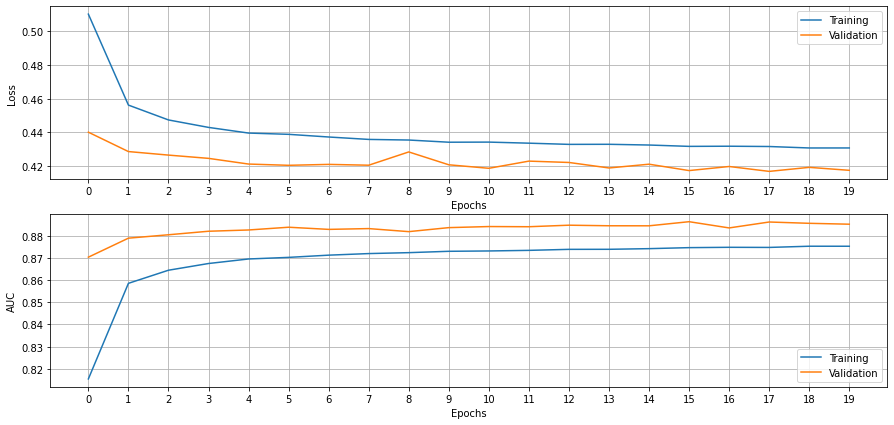

In [26]:
print("Train AUC: {:.3f}".format(roc_auc_score(y_0, neural_network.predict(X_0))))
print("Valid AUC: {:.3f}".format(roc_auc_score(y_1, neural_network.predict(X_1))))
print("Test  AUC: {:.3f}".format(roc_auc_score(y_2, neural_network.predict(X_2))))

plt.figure(figsize = (15, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xticks(range(0, len(history.history["loss"])))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.subplot(2, 1, 2)
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.xticks(range(0, len(history.history["loss"])))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["Training", "Validation"])
plt.show()